# Group 006-26 Project Report
#### Linda Han, Shaqed Orr, Eric Zhang, Prabhjot Singh

## Introduction:
There are a number of different factors that are attributed to different species of iris flowers. Our multivariable dataset provides information on sepal length, sepal width, petal length, and petal width, that we can use to predict the particular species of flower.


We want to predict the species of an iris flower given its:
1. sepal length in cm 
2. sepal width in cm
3. petal length in cm
4. petal width in cm


We will be using the Iris data set found on https://archive.ics.uci.edu/ml/datasets/iris. This set contains 3 classes of 50 instances each, where each class refers to a species of iris plant. The species are Iris Setosa, Iris Versicolour, and Iris Virginica


## Preliminary data analysis:
First, we load in all the necessary libraries.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) # this lists only 6 rows when we try to display the dataset

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Reading and cleaning the data

1) We read the iris dataset from the original source on the web (UCI Machine Learning Repository) using read_csv function

2) We added column names to reflect each of the attributes, as well as changed the data type of **class** column from character to factor. Our data is now tidy, as the dataset already has only one row per observation, each column is a single variable (either a measurement of the iris flower or its species), and each value is in a single cell.


In [10]:
iris_col <- c("sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm", "class")
iris <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", col_names= iris_col) %>% 
        mutate(class = as_factor(class))

iris

Parsed with column specification:
cols(
  sepal_length_cm = col_double(),
  sepal_width_cm = col_double(),
  petal_length_cm = col_double(),
  petal_width_cm = col_double(),
  class = col_character()
)



sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
⋮,⋮,⋮,⋮,⋮
6.5,3.0,5.2,2.0,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3.0,5.1,1.8,Iris-virginica


<br>

#### Summary of the training data

We set the seed to a random number to ensure the reproducibility of our result.

We then split the data into training (80%) and testing sets (20%). We chose this proportion because... TODO

In [5]:
set.seed(777)

iris_split <- initial_split(iris, prop = 0.80, strata = class)
iris_train <- training(iris_split)
iris_test <- testing(iris_split)

<br>

Using only the training data, we summarize the data into 2 tables and count the number of rows with missing values to check that all of our rows have values.

In [5]:
# Summarizes the average value of each column
iris_avg_size <- iris_train %>%
        summarize(across(sepal_length_cm:petal_width_cm, mean))
iris_avg_size

# Summarizes the number of observations in each class 
# (Iris-setosa, Iris-veriscolor, or Iris-virginica)
iris_class_count <- iris_train %>%
        count(class)
iris_class_count

# Counts the number of missing rows
sum(is.na(iris_train))

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
<dbl>,<dbl>,<dbl>,<dbl>
5.854472,3.06748,3.771545,1.198374


class,n
<fct>,<int>
Iris-setosa,41
Iris-versicolor,41
Iris-virginica,41


[1] 0

<br>

#### Visualization of the training data

Using only training data, we conduct an exploratory data analysis by visualizing the data with two scatterplots. In the first graph, we ... TODO. In the second graph, we ... TODO.

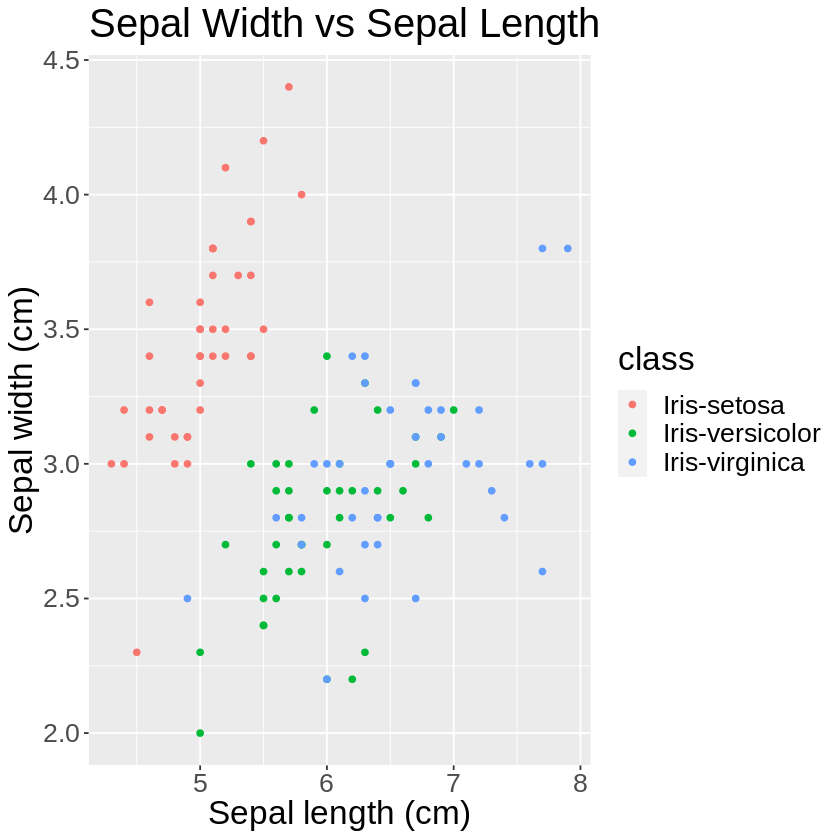

In [14]:
# Graph 1
iris_plot_sepal <- ggplot(data = iris_train, 
                          aes(x = sepal_length_cm, y = sepal_width_cm , colour = class )) +
                geom_point() +
                labs(x = "Sepal length (cm)", y = "Sepal width (cm)" , colour = "class") +
                ggtitle("Sepal Width vs Sepal Length") +
                theme(text = element_text(size = 20))

iris_plot_sepal

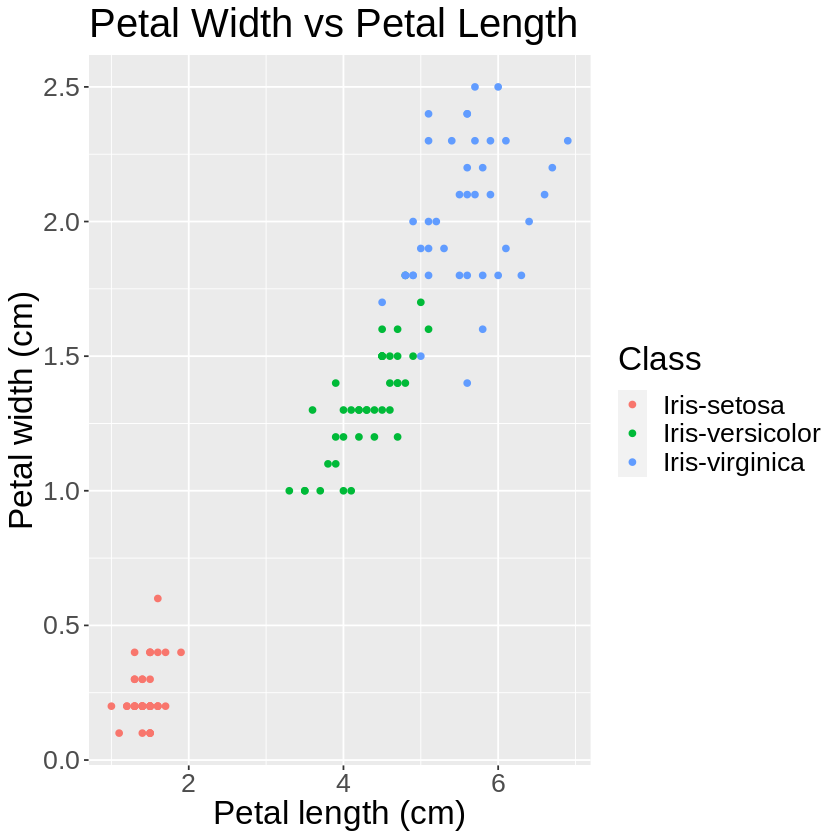

In [17]:
# Graph 2
iris_plot_petal <- ggplot(data = iris_train,
                          aes(x = petal_length_cm, y = petal_width_cm , colour = class )) +
                    geom_point() +
                    labs(x = "Petal length (cm)", y = "Petal width (cm)" , colour = "Class") +
                    ggtitle("Petal Width vs Petal Length") +
                    theme(text = element_text(size = 20))

iris_plot_petal

## Building The K-Nearest Neighbour Classifier

### Model Training Phase 

----------------------------

#### 1. Recipe 

Scale and center all predictors (is it needed? since they are have same unit (cm))

In [19]:
iris_recipe <- recipe(class ~ ., data = iris_train) %>% 
            step_center(all_predictors()) %>% 
            step_scale(all_predictors()) 

iris_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Centering for all_predictors()
Scaling for all_predictors()

<br>

To visualize the scaled iris_train data, we use prep and bake functions

In [21]:
iris_scaled <- iris_recipe %>% 
                prep() %>% 
                bake(iris_train)

iris_scaled

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.157990,-0.15110630,-1.329810,-1.308899,Iris-setosa
-1.400635,0.29675092,-1.385883,-1.308899,Iris-setosa
-1.521958,0.07282231,-1.273736,-1.308899,Iris-setosa
⋮,⋮,⋮,⋮,⋮
0.78317214,-0.1511063,0.8009859,1.0509564,Iris-virginica
0.41920423,0.7446081,0.9131331,1.4442657,Iris-virginica
0.05523632,-0.1511063,0.7449123,0.7887503,Iris-virginica


#### 2. Model Specification

We create a nearest neighbour model

In [25]:
iris_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
            set_engine("kknn") %>% 
            set_mode("classification")

iris_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### 3. vfold

#### 4. Workflow

#### 5. Collect Metrics

#### 6. Plot Neighbors vs Accuracy Graph

#### We find that the optimal $K$ is [unknown]

#### 7. Rebuild Model Specification and Workflow with $K$ = [unknown]

<br> 

### Model Testing Phase

------------------------

#### 1. Predict

#### 2. Assess accuracy of predictions

<br>

## Methods:

We will be splitting our data into 80% for training and 20% for the testing set. We will use the $K$-Nearest Neighbor method and tidymodels library functions to train our data. We will also perform cross-validation with 5 folds for finding the optimal $K$ value. Since we only have 4 variables(i.e. sepal length,sepal width, petal length,petal width) and all of them depict crucial measurements of the flower, we will be using them all for data analysis.

We plan to visualize the results using...
1. A confusion matrix
2. A scatterplot graph with coloured decision regions